### 正解データを用いたクラスタリング評価

In [2]:
import mglearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

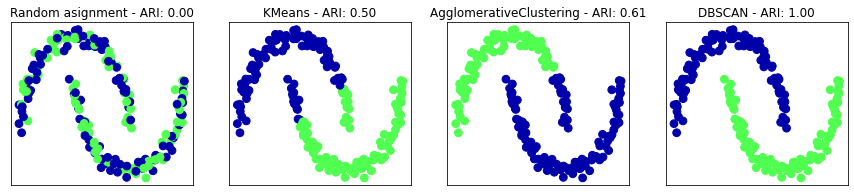

In [12]:
from sklearn.datasets import make_moons
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN


X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15,3), subplot_kw={"xticks":(), "yticks":()})

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

axes[0].scatter(X_scaled[:,0], X_scaled[:,1], c=random_clusters, cmap=mglearn.cm3, s=60)
axes[0].set_title("Random asignment - ARI: {:.2f}".format(adjusted_rand_score(y, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X[:,0], X[:,1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(y, clusters)))

In [13]:
from sklearn.metrics import accuracy_score

cluster1 = [0,0,1,1,0]
cluster2 = [1,1,0,0,1]

print("Accuracy: {:.2f}".format(accuracy_score(cluster1, cluster2)))
print("ARI: {:.2f}".format(adjusted_rand_score(cluster1, cluster2)))

Accuracy: 0.00
ARI: 1.00


### 正解データを用いないクラスタリング評価

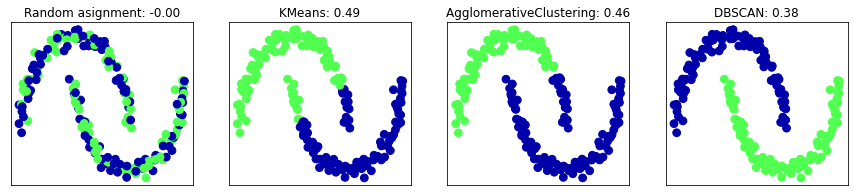

In [19]:
from sklearn.metrics.cluster import silhouette_score

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3), subplot_kw={"xticks":(), "yticks":()})

random_state = np.random.RandomState(seed=0)
random_cluster = random_state.randint(low=0, high=2, size=len(X))

axes[0].scatter(X_scaled[:,0], X_scaled[:,1], c=random_clusters, cmap=mglearn.cm3, s=60)
axes[0].set_title("Random asignment: {:.2f}".format(silhouette_score(X_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

for ax, algorithm in zip( axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X[:,0], X[:,1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{}: {:.2f}".format(algorithm.__class__.__name__, silhouette_score(X_scaled, clusters)))


### 顔画像データセットを用いたアルゴリズムの比較

In [20]:
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

X_people = X_people / 255.

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(X_people)
X_pca = pca.transform(X_people)

DBSCAN、デフォルトだとノイズだと判断される

In [22]:
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


min_samplesの値を小さくしても効果はない

In [23]:
dbscan = DBSCAN(min_samples=3)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


espの値を増やす

In [24]:
dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1  0]


クラスタとノイズのデータポイントを数える

In [25]:
print("Number of points per cluster: {}".format(np.bincount(labels + 1)))

Number of points per cluster: [  31 1945]


ノイズとなった画像の確認

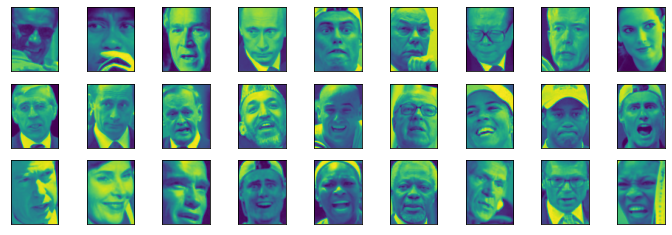

In [27]:
noise = X_people[labels==-1]
fig, axes = plt.subplots(3, 9, subplot_kw={"xticks":(), "yticks":()}, figsize=(12,4))
for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

In [29]:
for eps in [1,3,5,7,9,11]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print("Clusters present: {}".format(np.unique(labels)))
    print("Clusters sizes: {}".format(np.bincount(labels+1)))


eps=1
Clusters present: [-1]
Clusters sizes: [1976]

eps=3
Clusters present: [-1]
Clusters sizes: [1976]

eps=5
Clusters present: [-1]
Clusters sizes: [1976]

eps=7
Clusters present: [-1  0  1  2  3  4  5  6  7]
Clusters sizes: [1920   19   14    3    3    3    7    3    4]

eps=9
Clusters present: [-1  0  1  2  3]
Clusters sizes: [1212  754    3    4    3]

eps=11
Clusters present: [-1  0]
Clusters sizes: [ 393 1583]


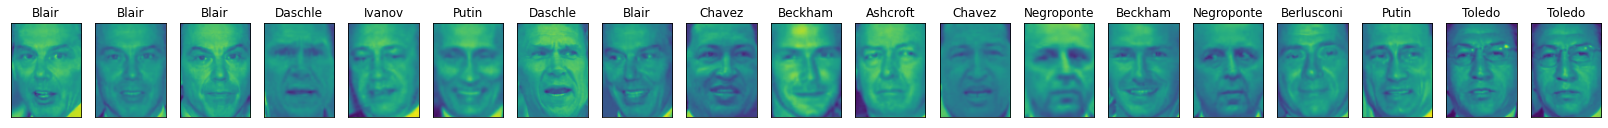

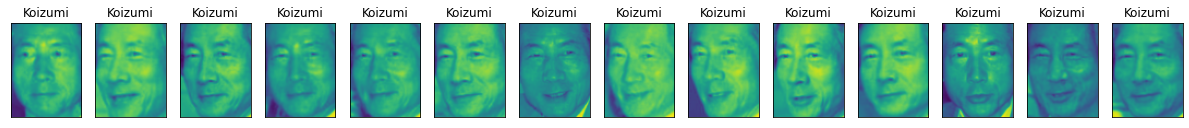

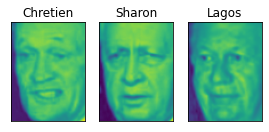

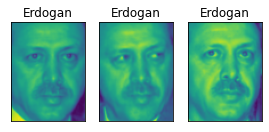

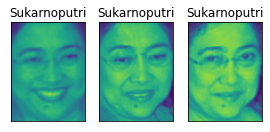

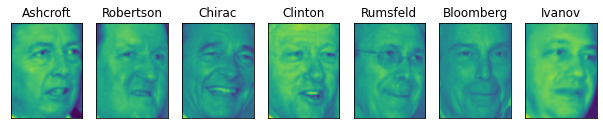

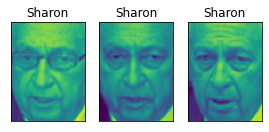

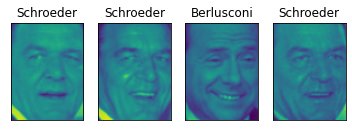

In [33]:
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images = np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4), subplot_kw={"xticks":(), "yticks":()})
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])

#### k-meansによる解析

In [34]:
km = KMeans(n_clusters=10, random_state=0)
labels_km = km.fit_predict(X_pca)
print("Cluster sizes k-means: {}".format(np.bincount(labels_km)))

Cluster sizes k-means: [191 243 130 218 298 114 296  85 147 254]


画像化したクラスタセンタの確認

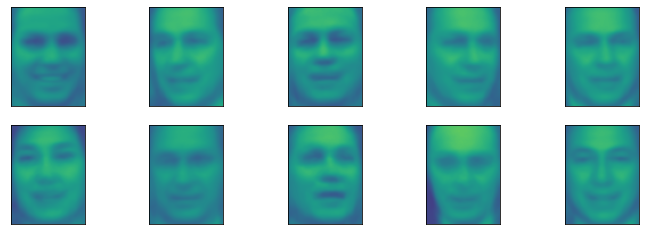

In [35]:
fig, axes = plt.subplots(2, 5, subplot_kw={"xticks":(), "yticks":()}, figsize=(12,4))
for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape), vmin=0, vmax=1)


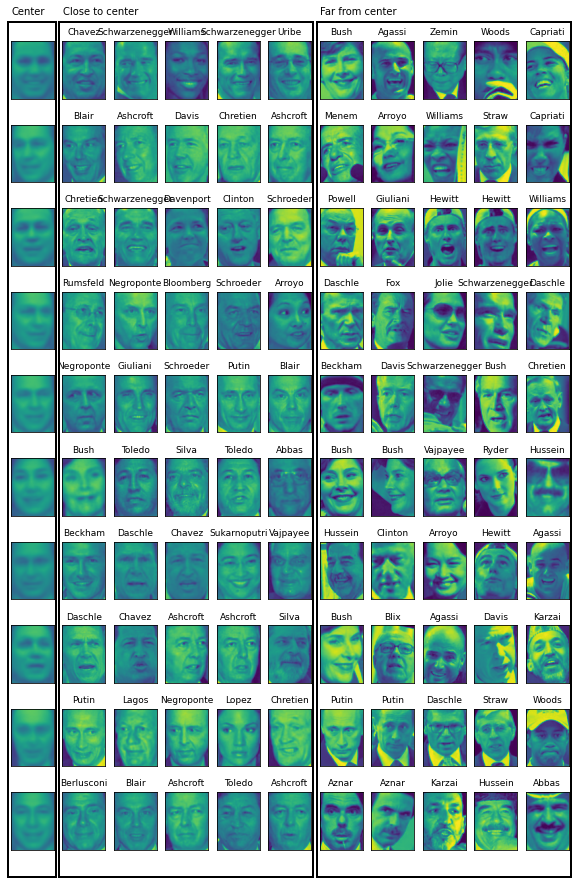

In [36]:
mglearn.plots.plot_kmeans_faces(km, pca, X_pca, X_people, y_people, people.target_names)